# Importing Necessary Libraries

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

In [80]:
df = pd.read_csv("Datasets/pulsar_data_train.csv")

In [81]:
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [82]:
df.shape

(12528, 9)

## Tasks Performed to ready the dataset for SVM
- Class Imbalance: Discovery and Handling
- Missing Values: Dicovery and Handling
- Check Stastistics, Duplicates, and datatypes
- Outliers: Identification and Treatment
- Data Visualization: Univariant and Bivariant Analysis
- Data Transformation and Feature Engineering: Normalization and Standardization

# Missing Values: Discovery and Handling

In [83]:
df.isna().sum()

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64

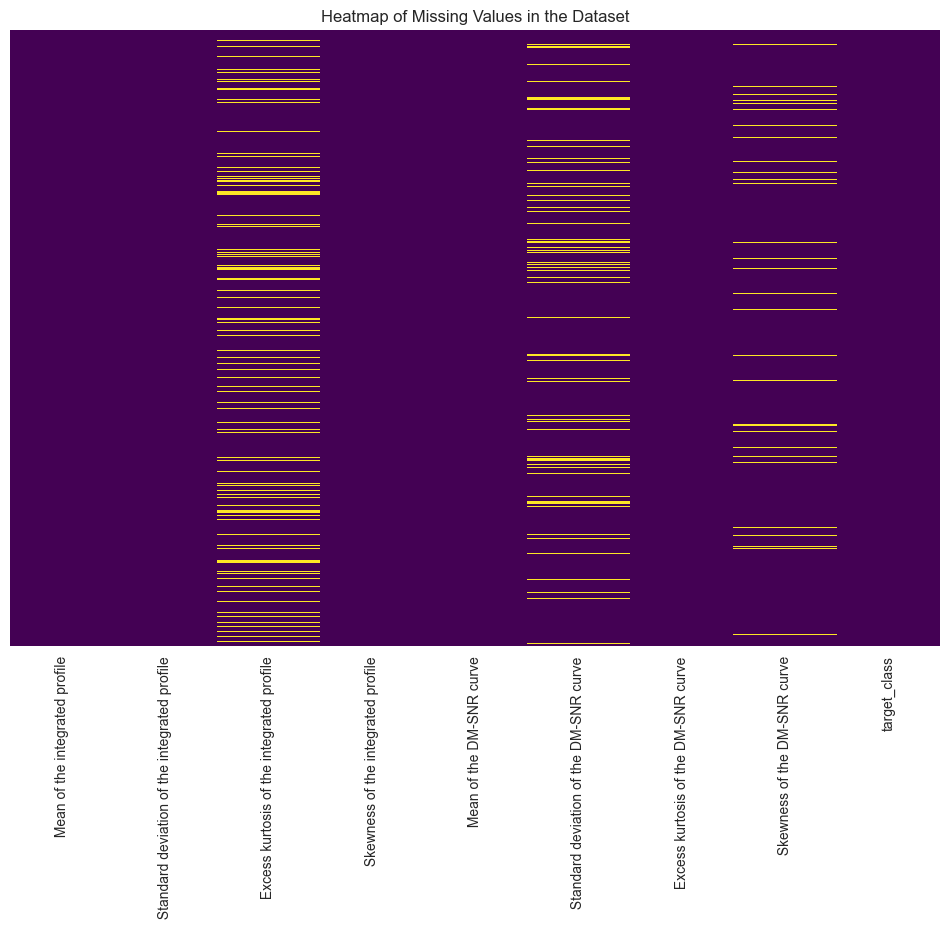

In [84]:
# Create a mask for missing values
missing_mask = df.isnull()

# Plotting the missing values heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(missing_mask, cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of Missing Values in the Dataset')
plt.show()




The heatmap of missing values shows where in the dataset the missing values are located, but it doesn't reveal a clear pattern. The missing values are spread out and not concentrated in specific rows or blocks, which might suggest that the data could be missing at random.

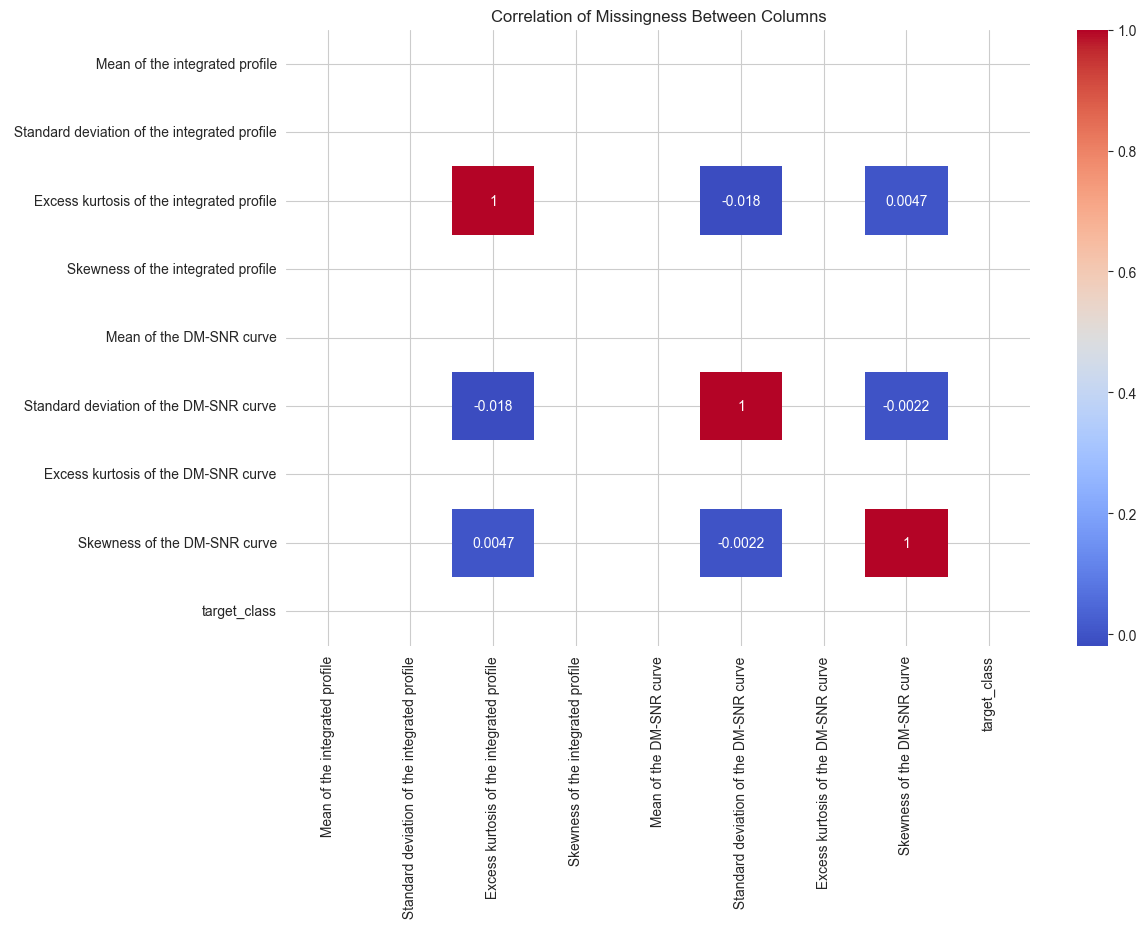

In [85]:
# Calculating the correlation of missingness between columns
# We are using the mask where True is 1 and False is 0, hence we can calculate the correlation between these binary values
missing_corr = missing_mask.corr()

# Displaying the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm')
plt.title('Correlation of Missingness Between Columns')
plt.show()

The correlation heatmap of missingness between columns indicates that there is no strong correlation between the missingness of one column and another. Most correlations are very low, suggesting that the presence or absence of data in one column does not imply the presence or absence of data in another.

In [86]:
# Display the percentage of missing values in each column
missing_percentage = df.isnull().mean() * 100
missing_percentage

 Mean of the integrated profile                   0.000000
 Standard deviation of the integrated profile     0.000000
 Excess kurtosis of the integrated profile       13.848978
 Skewness of the integrated profile               0.000000
 Mean of the DM-SNR curve                         0.000000
 Standard deviation of the DM-SNR curve           9.402937
 Excess kurtosis of the DM-SNR curve              0.000000
 Skewness of the DM-SNR curve                     4.988825
target_class                                      0.000000
dtype: float64

The percentage of missing values in each column is as follows:

- Excess kurtosis of the integrated profile: 13.85%
- Standard deviation of the DM-SNR curve: 9.40%
- Skewness of the DM-SNR curve: 4.99%

Becuase there is no pattern in the missing values of these columns, I assume it is not safe to delete any rows from these columns.

So, I am going to implement imputation. 

For it, i need to check data distribution. Lets do it. 

In [87]:
# Calculating the skewness and kurtosis for the columns with missing values
columns_with_missing_values = [' Excess kurtosis of the integrated profile',
                               ' Standard deviation of the DM-SNR curve',
                               ' Skewness of the DM-SNR curve']

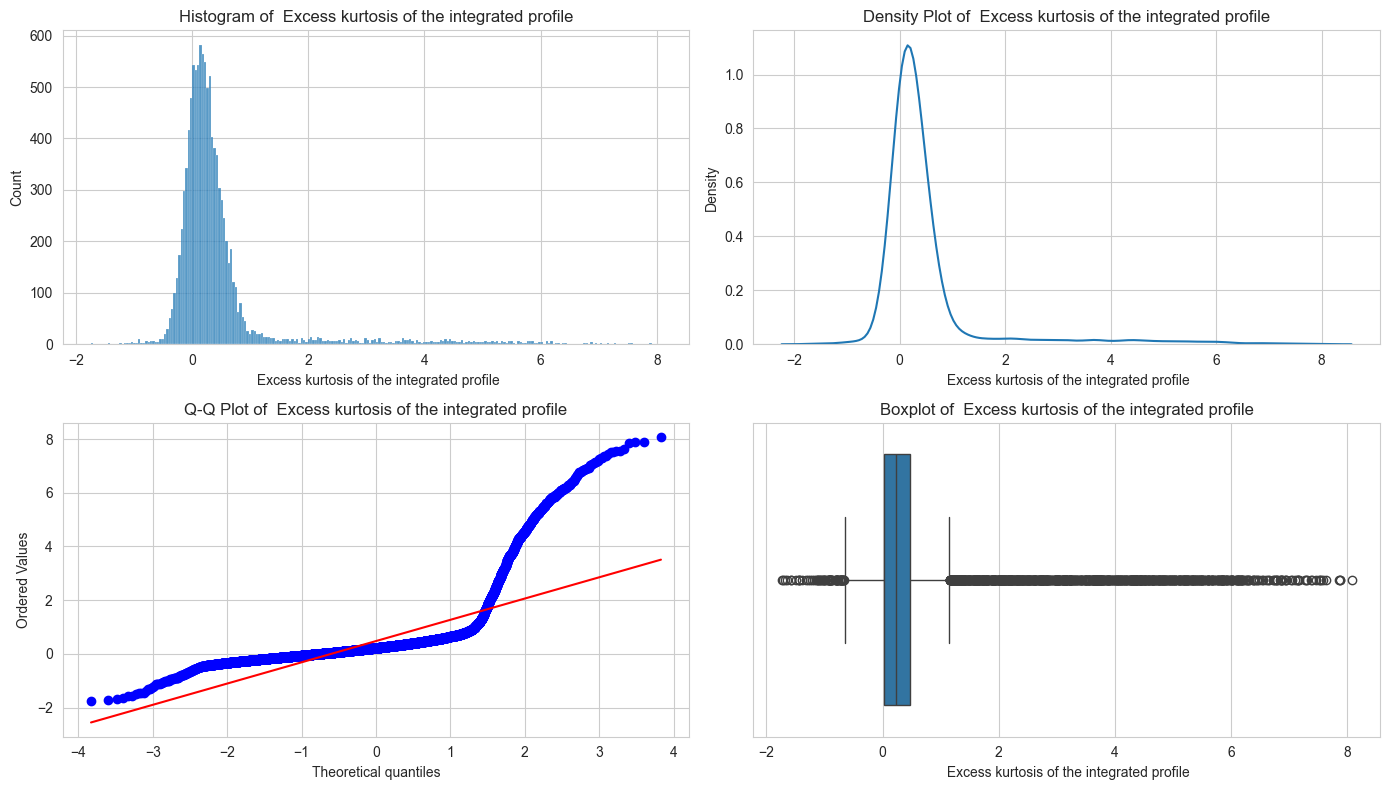

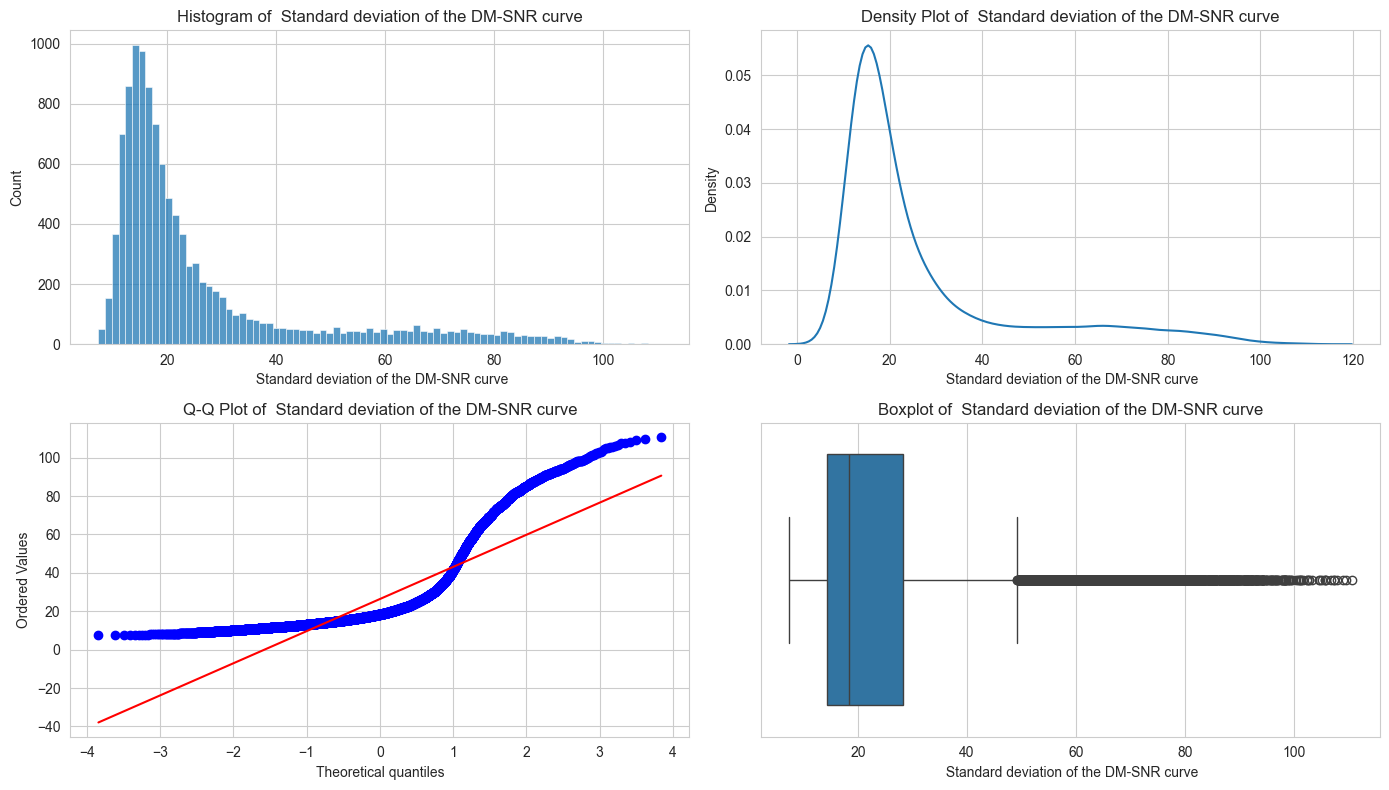

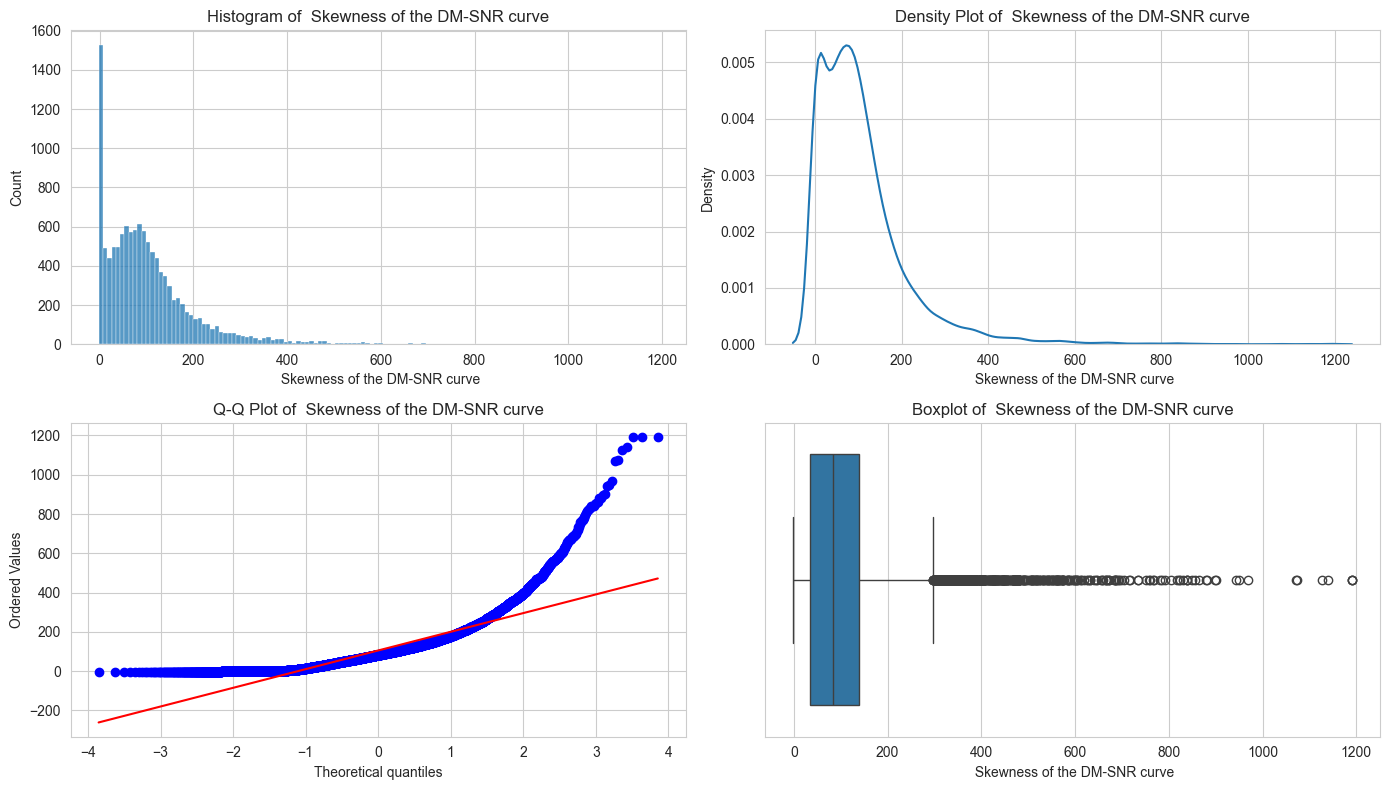

In [88]:
from scipy import stats

# Defining a function to plot histograms, density plots, and Q-Q plots
def plot_distribution(column_name):
    # Remove NaN values for plotting
    data = df[column_name].dropna()
    
    # Set up the matplotlib figure
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    # Histogram
    sns.histplot(data, kde=False, ax=axs[0, 0])
    axs[0, 0].set_title(f'Histogram of {column_name}')

    # Density Plot
    sns.kdeplot(data, ax=axs[0, 1])
    axs[0, 1].set_title(f'Density Plot of {column_name}')

    # Q-Q plot
    stats.probplot(data, dist="norm", plot=axs[1, 0])
    axs[1, 0].set_title(f'Q-Q Plot of {column_name}')

    # Boxplot
    sns.boxplot(x=data, ax=axs[1, 1])
    axs[1, 1].set_title(f'Boxplot of {column_name}')

    plt.tight_layout()
    plt.show()

# Plotting distributions
for column in columns_with_missing_values:
    plot_distribution(column)




The visual and statistical tests suggest the following for the columns with missing values:

1. Excess kurtosis of the integrated profile: 
- Histogram and Density Plot: The distribution does not appear to be normal; it is heavily skewed.
- Q-Q Plot: The data points do not lie on the line, indicating that the distribution deviates from normality.
- Shapiro-Wilk Test: The p-value is 0.0, which is below the common alpha level of 0.05, leading us to reject the null hypothesis and conclude that the data is not normally distributed.

2. Standard deviation of the DM-SNR curve:

- The distribution is also skewed, as seen in the Histogram and Density Plot.
- The Q-Q Plot shows deviations from the line, especially in the tails.
- The Shapiro-Wilk Test confirms non-normality with a p-value of 0.0.

3. Skewness of the DM-SNR curve:

- Again, the Histogram and Density Plot indicate a skewed distribution.
- The Q-Q Plot shows a deviation from normality.
- The Shapiro-Wilk Test p-value of 0.0 indicates the data is not normally distributed.

In [89]:
# Shapiro-Wilk Test
shapiro_results = {}
for column in columns_with_missing_values:
    shapiro_test_stat, shapiro_p_value = stats.shapiro(df[column].dropna())
    shapiro_results[column] = {'Shapiro-Wilk Test Statistic': shapiro_test_stat, 'p-value': shapiro_p_value}

shapiro_results

{' Excess kurtosis of the integrated profile': {'Shapiro-Wilk Test Statistic': 0.5524154287515255,
  'p-value': 6.711449339215708e-97},
 ' Standard deviation of the DM-SNR curve': {'Shapiro-Wilk Test Statistic': 0.7271921650141079,
  'p-value': 1.9571254194167016e-86},
 ' Skewness of the DM-SNR curve': {'Shapiro-Wilk Test Statistic': 0.7836843739303044,
  'p-value': 2.742153510650096e-82}}

From the visualizations, Shapiro-Wilk Test, and p-value, we can conclude that these columns's data is skewed. So, for imputation we have the following options:

- Median Imputation
- Model based imputation

I would prefer Model-based imputation becuase of following characteristics of the of missing values columns:

- The missing data is not a large percentage of the dataset (ranging from about 5% to 14% missing).
- The data appears to be non-normally distributed and skewed.
- We likely have complex relationships in our data given the scientific nature of the dataset.

Multiple Imputation by Chained Equations (MICE) is the best imputation method for our dataset because it is versatile and can handle the complexity and potential non-linear relationships in our data.


In [90]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Initialize the imputer
df_imputed = IterativeImputer()
# Fit and transform the data
df_imputed = pd.DataFrame(df_imputed.fit_transform(df), columns=df.columns)

In [91]:
df_imputed.isna().sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

# Check Statistics, Duplicates and Datatypes

In [92]:
df_imputed.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000
mean,111.041841,46.521437,0.480024,1.778431,12.674758,26.307254,8.333489,105.846054,0.092034
std,25.672828,6.801077,1.063722,6.208450,29.613230,19.419635,4.535783,107.326556,0.289085
min,5.812500,24.772042,-1.738021,-1.791886,0.213211,-2.504152,-3.139270,-45.642118,0.000000
25%,100.871094,42.362222,0.025792,-0.188142,1.910535,14.421526,5.803063,35.091816,0.000000
50%,115.183594,46.931022,0.223575,0.203317,2.792642,18.625115,8.451097,83.443097,0.000000
75%,127.109375,50.979103,0.474347,0.932374,5.413253,28.536578,10.727927,140.780992,0.000000
max,189.734375,91.808628,8.069522,68.101622,222.421405,110.642211,34.539844,1191.000837,1.000000


In [93]:
# Check for duplicates
duplicates = df_imputed.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [94]:
# Check data types of features
print(df_imputed.dtypes)

 Mean of the integrated profile                  float64
 Standard deviation of the integrated profile    float64
 Excess kurtosis of the integrated profile       float64
 Skewness of the integrated profile              float64
 Mean of the DM-SNR curve                        float64
 Standard deviation of the DM-SNR curve          float64
 Excess kurtosis of the DM-SNR curve             float64
 Skewness of the DM-SNR curve                    float64
target_class                                     float64
dtype: object


# Outliers: Identification and Treatment

1. **Identification**

To identify outliers in this dataset, we are using the Interquartile Range (IQR) method for each numerical feature. Outliers can be defined as values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR for that feature, where Q1 and Q3 are the first and third quartiles, respectively.

In [95]:
# Calculating IQR for each feature to identify outliers
Q1 = df_imputed.quantile(0.25)
Q3 = df_imputed.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = ((df_imputed < (Q1 - 1.5 * IQR)) | (df_imputed > (Q3 + 1.5 * IQR))).any(axis=1)

# Counting the number of outliers
outliers_count = outliers.sum()

# Percentage of data points that are outliers
outliers_percentage = (outliers_count / len(df_imputed)) * 100

outliers_count, outliers_percentage


(3310, 26.42081736909323)

Out of the total entries in the dataset, 3,310 are identified as outliers based on the Interquartile Range (IQR) method. This constitutes approximately 26.42% of the dataset.

As our dataset is in the domain of astronomy where such extremes could signify important discoveries or phenomena. Removing or treating a large portion of data as outliers could potentially lead to loss of valuable information.

Let's do closer examination of these outliers to understand their nature and impact on the dataset.

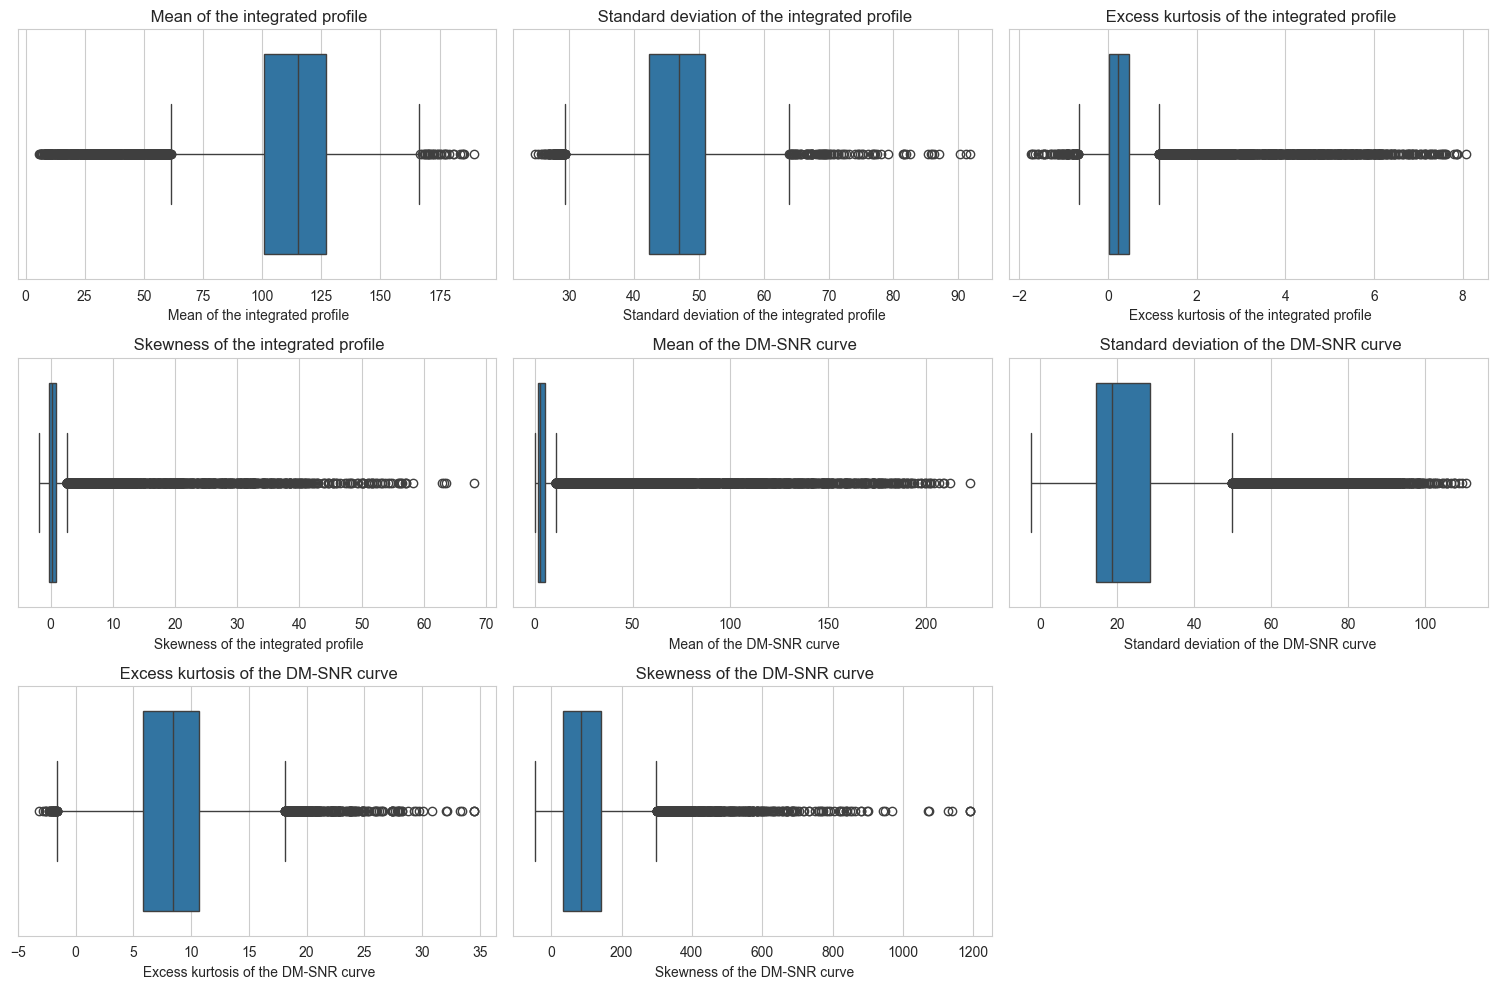

In [96]:
# Setting the size of the plots
plt.figure(figsize=(15, 10))

# Creating box plots for each feature to visualize outliers
for i, column in enumerate(df_imputed.columns[:-1], 1):  # Exclude target_class for plotting
    plt.subplot(3, 3, i)
    sns.boxplot(x=df_imputed[column])
    plt.title(column)

plt.tight_layout()
plt.show()


The box plots for each feature show the distribution of values and highlight the presence of outliers in the dataset. Here's a summary of what the visualizations reveal:

- Integrated Profile Features: These features show a mix of distributions, with the excess kurtosis and skewness of the integrated profile showing a significant number of high-value outliers. This suggests that there are pulsar candidates with unusually shaped integrated profiles.
- DM-SNR Curve Features: Similar to the integrated profile features, we see a wide range of outlier values, especially in the excess kurtosis and skewness of the DM-SNR curve. The outliers in these features are skewed towards higher values, indicating candidates with distinct DM-SNR characteristics.
- Mean and Standard Deviation: Both for the integrated profile and the DM-SNR curve, the mean and standard deviation features also show outliers, though the spread and impact seem less pronounced compared to the kurtosis and skewness features.

Considering the nature of the data and the domain, the outliers, especially those with extreme kurtosis and skewness, could be of significant interest. These outliers might represent rare or unusual pulsar candidates.

2. **Treatment**

Importan*

Outliers Handling: As SVMs aim to maximize the margin between classes, outliers can have a significant impact on the position of the hyperplane. Given the substantial number of outliers identified in our dataset, it’s crucial to decide how to handle them also taking the consideration that these outliers might represent rare or unusual pulsar candidates.

Let's begin by Winsorizing the data to cap extreme outliers, as it's a balanced approach between retaining data and reducing the impact of outliers. We'll apply Winsorizing to the entire dataset, capping values at the 1st and 98th percentiles. This approach will ensure that we retain the majority of our data while limiting the most extreme outliers' influence.

In [97]:
from scipy.stats.mstats import winsorize

# Winsorizing each feature separately at 1% and 98% percentiles
for column in df_imputed.columns[:-1]:  # Exclude the target_class
    df_imputed[column] = winsorize(df_imputed[column], limits=[0.01, 0.02])

# Check the first few rows to ensure the transformation was applied
df_imputed.head()


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,150.070312,48.865942,-0.215989,-0.171294,17.471572,46.376201,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


The data has been successfully winsorized, with extreme outliers capped at the 1st and 99th percentiles for each feature. This method limits the impact of the most extreme outliers while preserving the majority of the data, which is essential for maintaining the integrity of potential pulsar observations.

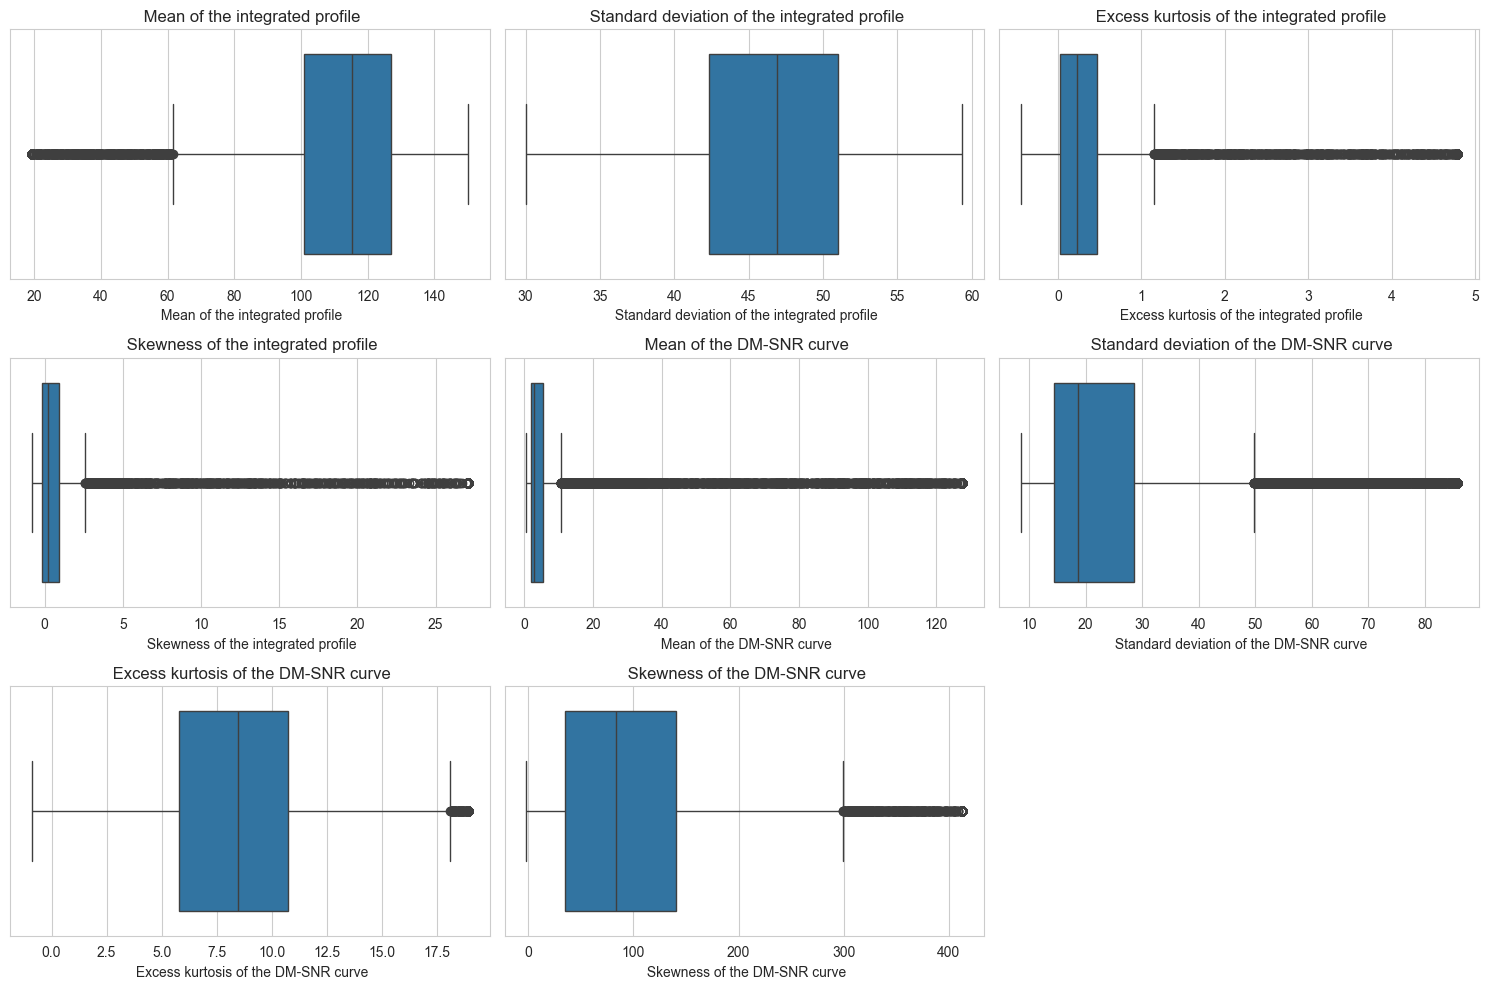

In [98]:
# Setting the size of the plots
plt.figure(figsize=(15, 10))

# Creating box plots for each feature to visualize outliers
for i, column in enumerate(df_imputed.columns[:-1], 1):  # Exclude target_class for plotting
    plt.subplot(3, 3, i)
    sns.boxplot(x=df_imputed[column])
    plt.title(column)

plt.tight_layout()
plt.show()


The revisualization of the dataset using box plots after winsorization shows the distributions of the features. The impact of winsorization can be observed through the reduced range of outlier values, indicating that the most extreme outliers have been effectively capped at the predetermined percentiles.

# Data Visualization

## Univariate Analysis

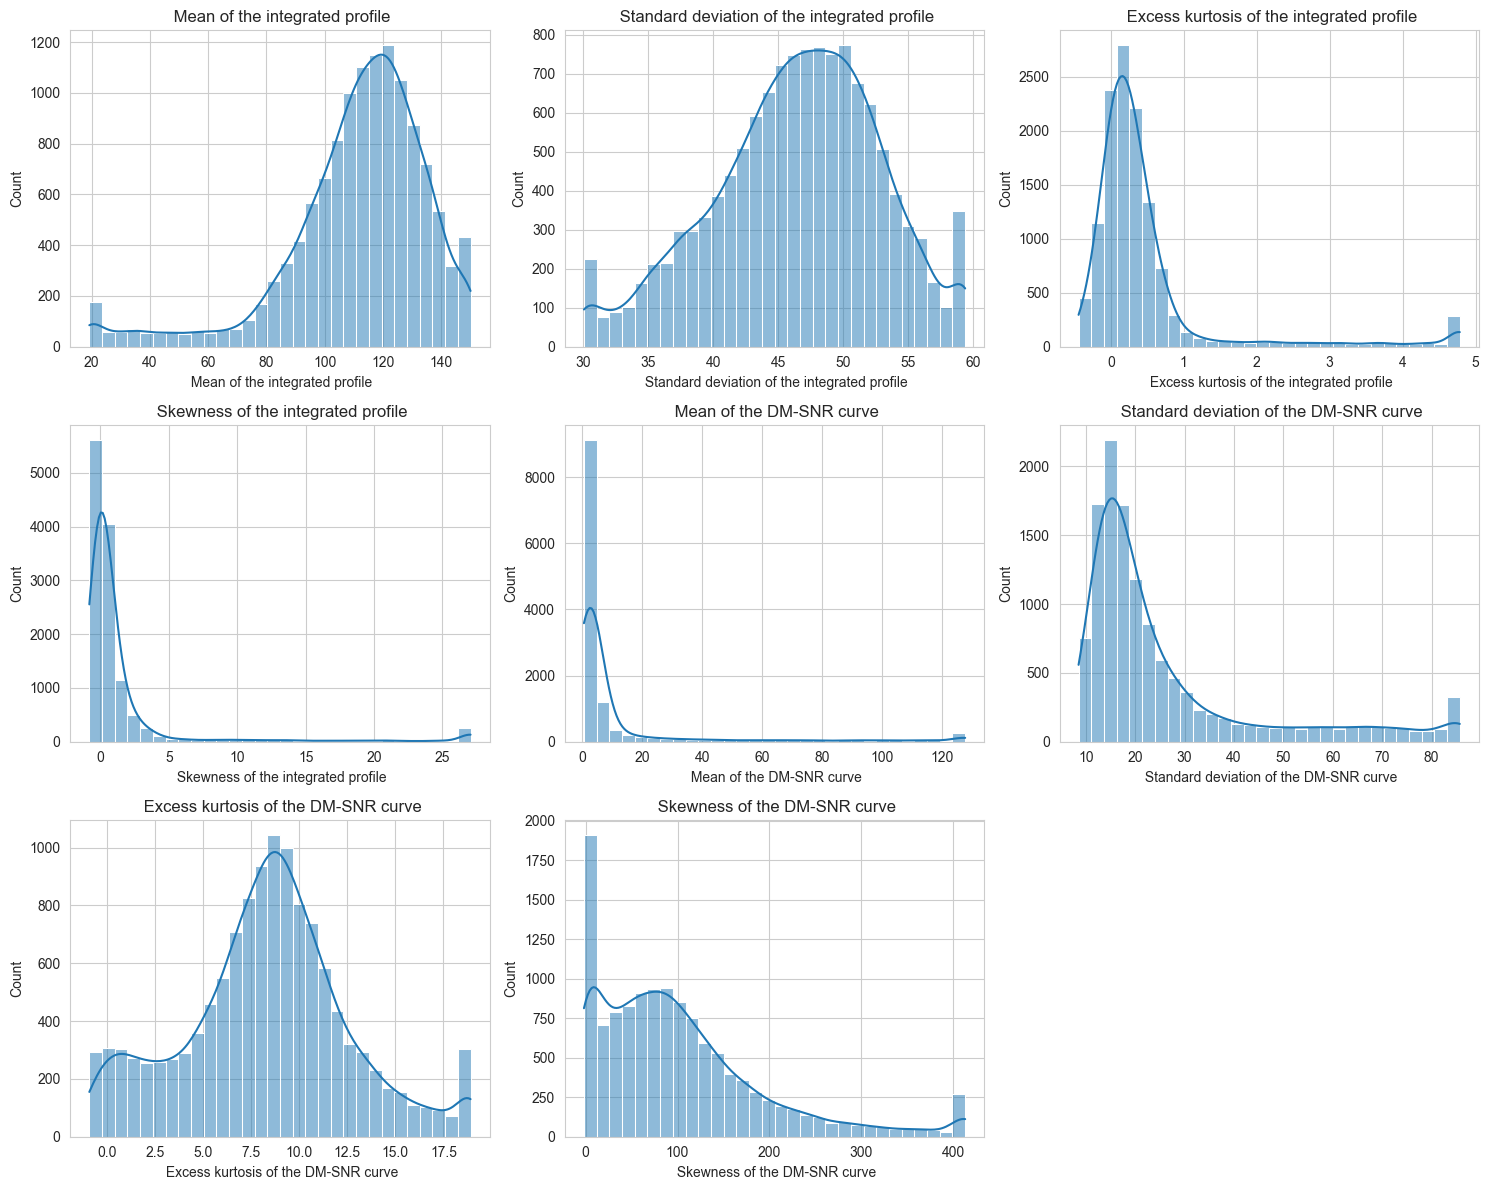

In [99]:
# Univariate Analysis: Plotting histograms for each feature to understand their distribution

plt.figure(figsize=(15, 12))

for i, column in enumerate(df_imputed.columns[:-1], 1):  # Exclude target_class for plotting
    plt.subplot(3, 3, i)
    sns.histplot(df_imputed[column], kde=True, bins=30)
    plt.title(column)

plt.tight_layout()
plt.show()


The histograms provide insights into the distribution of each feature in the dataset:

- Mean and Standard Deviation of Integrated Profile: These features show relatively normal distributions, indicating that the majority of pulsar candidates have similar mean brightness and variability in their integrated profiles.
- Excess Kurtosis and Skewness of Integrated Profile: The distributions of these features are skewed, suggesting variability in the shape of the pulsar signal profiles across candidates. Excess kurtosis indicates the "tailedness" of the distribution, while skewness indicates asymmetry.
- Mean and Standard Deviation of the DM-SNR Curve: Similar to the integrated profile's mean and standard deviation, these features exhibit somewhat normal distributions but with potential skewness, indicating variation in the signal's strength and variability over the dispersion measure.
- Excess Kurtosis and Skewness of the DM-SNR Curve: These features show highly skewed distributions, highlighting significant variability among candidates in terms of the tail heaviness and asymmetry of their DM-SNR curves.

## Bivariate Analysis

Now, we'll proceed to Bivariate Analysis to explore relationships between features and the target variable.

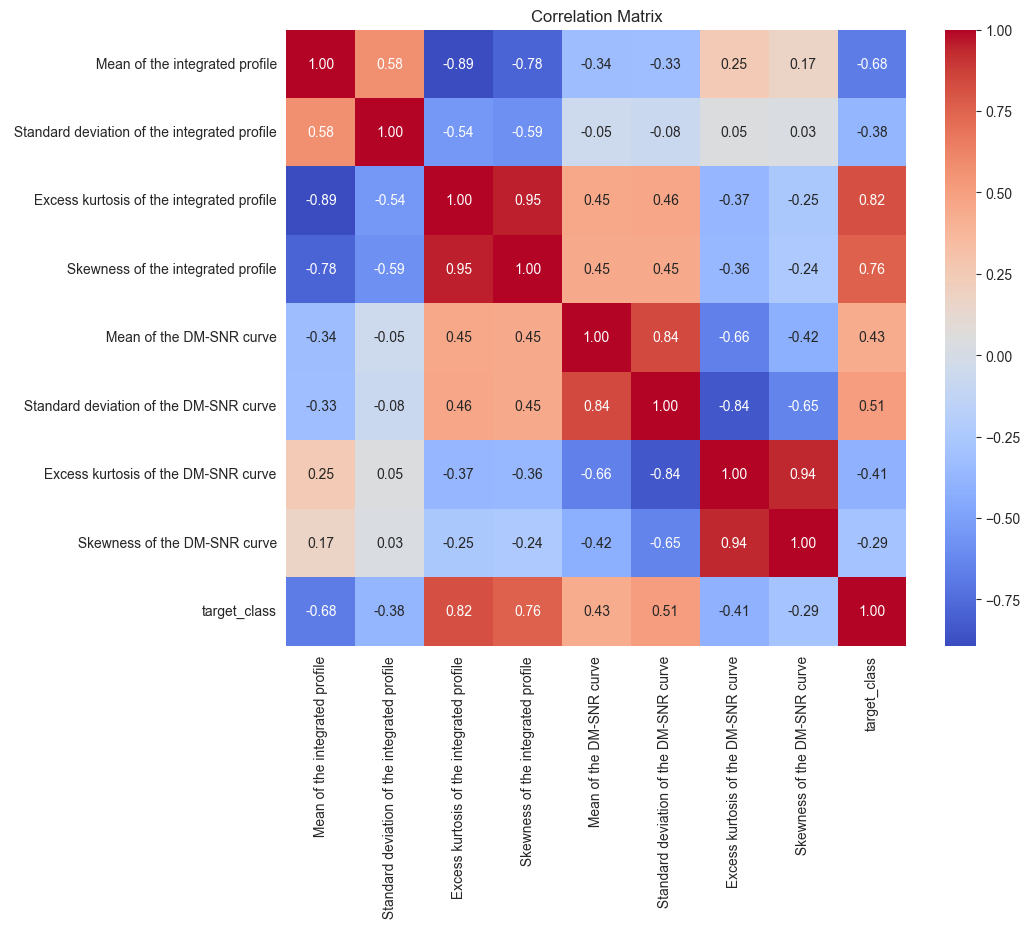

In [100]:
# Bivariate Analysis: Computing and visualizing the correlation matrix

plt.figure(figsize=(10, 8))
corr_matrix = df_imputed.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


he correlation matrix visualizes the relationships between the features and the target variable, as well as among the features themselves. Here are some key observations:

- Relationships with Target Variable: Certain features show stronger correlations with the target variable, indicating their potential importance in predicting whether a candidate is a pulsar. Notably, the excess kurtosis and skewness of both the integrated profile and the DM-SNR curve exhibit significant correlations with the target class.

- Among Features: There are correlations between certain pairs of features, such as between the mean and standard deviation of the integrated profile, as well as between the excess kurtosis and skewness of the DM-SNR curve. These relationships suggest that some features may carry similar information, which could be important for feature selection and engineering.

Given these insights, it might be useful to further explore the relationships that show significant correlation with the target variable through scatter plots or other bivariate analysis methods.

For the further bivariate analysis, let's focus on how the most correlated features with the target variable distribute across the two classes (pulsar and non-pulsar). This will help us understand if certain feature values are more indicative of a candidate being a pulsar or not.

We will:
- Plot the distribution of the most correlated features with the target variable for each class separately. This can help us see if there's a clear distinction in the feature values between the two classes.
- Specifically, we'll look at the excess kurtosis and skewness of both the integrated profile and the DM-SNR curve, as these features showed significant correlations with the target variable.

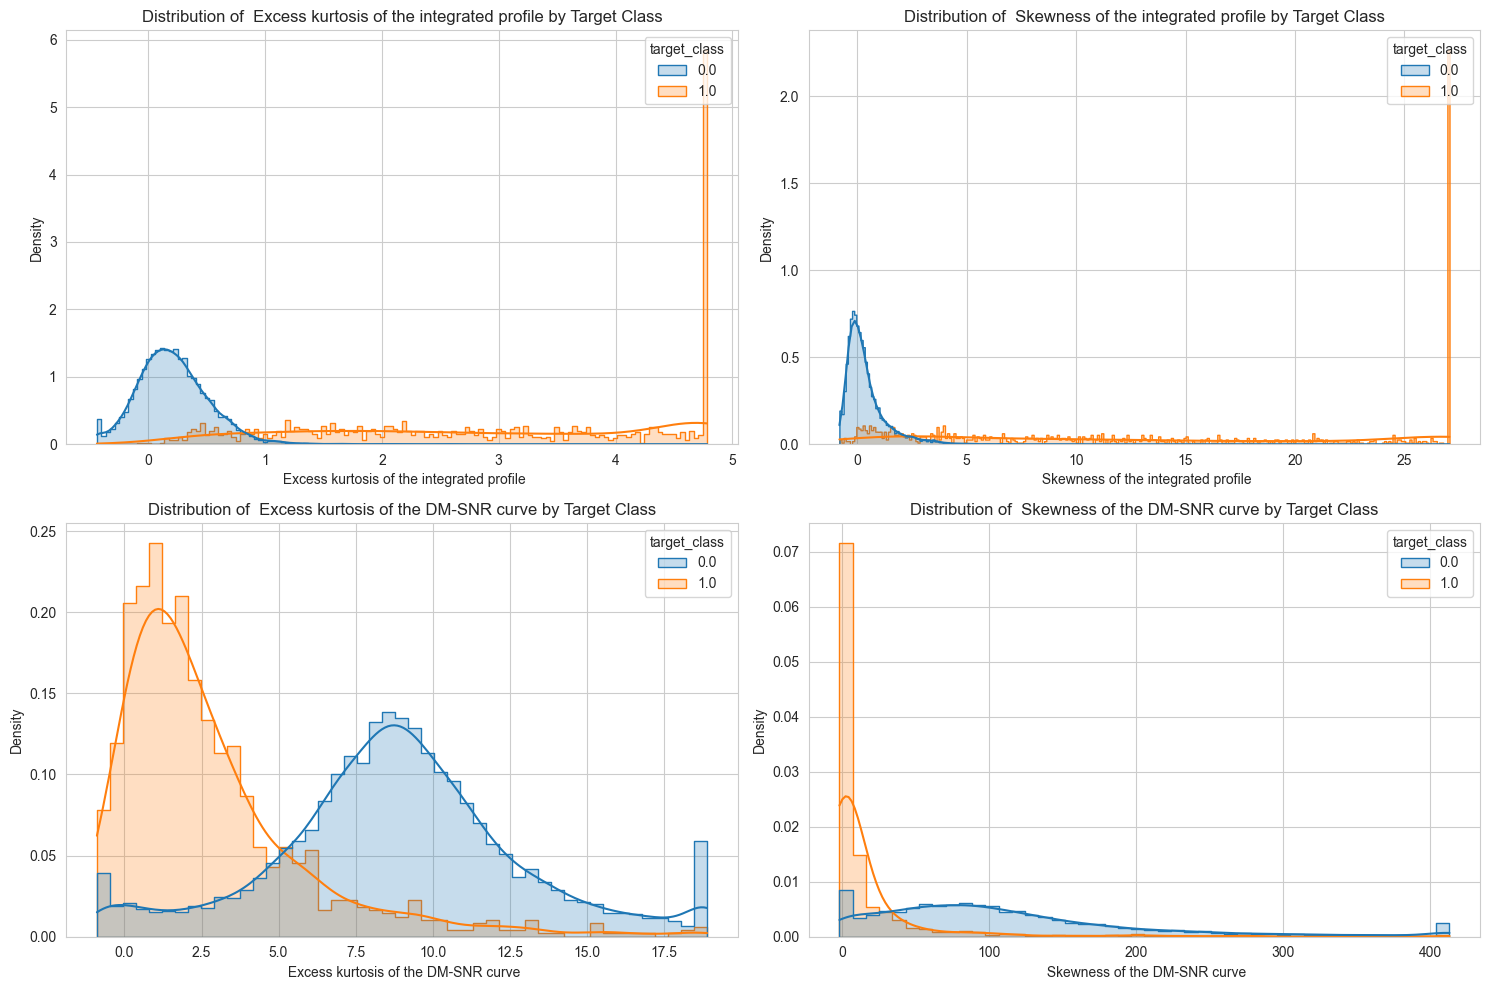

In [101]:
# Selecting the most correlated features based on the correlation matrix
features_of_interest = [
    ' Excess kurtosis of the integrated profile',
    ' Skewness of the integrated profile',
    ' Excess kurtosis of the DM-SNR curve',
    ' Skewness of the DM-SNR curve'
]

# Plotting distributions of the most correlated features by target class
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_of_interest, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_imputed, x=feature, hue="target_class", element="step", stat="density", common_norm=False, kde=True)
    plt.title(f'Distribution of {feature} by Target Class')

plt.tight_layout()
plt.show()



The histograms show the distributions of the most correlated features with the target variable, separated by the target class (pulsar vs. non-pulsar). Here are the insights from these plots:

- **Excess Kurtosis of the Integrated Profile**: There's a clear distinction between the two classes, with pulsar candidates generally having higher excess kurtosis values. This suggests that pulsar candidates tend to have more "tailed" profiles.
  
- **Skewness of the Integrated Profile**: Similar to excess kurtosis, skewness shows a differentiation between classes. Pulsar candidates often exhibit higher skewness, indicating asymmetrical profiles leaning towards higher values.
  
- **Excess Kurtosis of the DM-SNR Curve**: This feature also distinguishes between pulsar and non-pulsar candidates, with pulsar candidates typically showing lower excess kurtosis, suggesting less "tailed" DM-SNR curves among pulsars.
  
- **Skewness of the DM-SNR Curve**: Like the excess kurtosis of the DM-SNR curve, skewness shows a clear distinction, with pulsar candidates usually having lower skewness values, indicating less asymmetric DM-SNR curves.

These visualizations highlight the significant differences in the distributions of key features between pulsar and non-pulsar candidates. Such differences suggest these features are valuable for distinguishing between the two classes, supporting their use in predictive modeling.

# Data Transformation and Feature Engineering: Normalization and Standardization

Moving into the feature engineering part, we'll address the following key aspects based on the insights gained from the exploratory data analysis:

1. **Normalization and Standardization**: Since SVMs are sensitive to the magnitude of input features, we'll standardize the features to have a mean of 0 and a standard deviation of 1. This step ensures that all features contribute equally to the distance calculations used by the SVM.

2. **Skewness Reduction**: For features with significant skewness, we'll apply transformations to make their distributions more normal.

1. **Normalization and Standardization**

In [102]:
from sklearn.preprocessing import StandardScaler

# Separating features and target variable
X = df_imputed.drop("target_class", axis=1)
y = df_imputed["target_class"]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creating a new DataFrame with the standardized features
df_imputed_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Adding the target variable back to the DataFrame
df_imputed_scaled['target_class'] = y.values


In [103]:
# Display the first few rows of the standardized DataFrame
df_imputed_scaled.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,0.406152,0.301691,-0.091199,-0.323356,-0.334330,-0.411782,-0.190285,-0.406213,0.0
1,-1.351539,-1.591748,0.263227,0.372761,-0.363243,-0.455550,0.265557,-0.000416,0.0
2,0.781246,1.055589,-0.345480,-0.381485,-0.350327,-0.202385,0.055292,-0.310370,0.0
3,1.556296,0.378216,-0.712493,-0.355713,0.203254,1.066391,-1.232413,-1.032367,0.0
4,-1.039841,-1.600735,0.380994,0.349312,-0.348567,-0.294559,0.031313,-0.285957,0.0


The features in the dataset `df_imputed` have been successfully standardized, ensuring each feature has a mean of 0 and a standard deviation of 1. This standardization process is crucial for the SVM model, as it relies on the calculation of distances between data points; standardization ensures that each feature contributes equally to these calculations.


2. **Skewness Reduction**

We will apply the square root transformation to the most positively skewed features identified:

- **Excess Kurtosis of the Integrated Profile**
- **Skewness of the Integrated Profile**
- **Mean of the DM-SNR Curve**
- **Standard Deviation of the DM-SNR Curve**
- **Skewness of the DM-SNR Curve**

Let's apply the square root transformation to these selected features, taking the absolute value first to handle any negative values due to standardization.


In [104]:
# Features to transform due to high skewness
features_to_transform = [
    ' Excess kurtosis of the integrated profile',
    ' Skewness of the integrated profile',
    ' Mean of the DM-SNR curve',
    ' Standard deviation of the DM-SNR curve',
    ' Skewness of the DM-SNR curve'
]

# Applying square root transformation to selected features
for feature in features_to_transform:
    df_imputed_scaled[feature] = df_imputed_scaled[feature].apply(lambda x: np.sqrt(np.abs(x)))

# Recalculating skewness after transformation
new_skewness = df_imputed_scaled[features_to_transform].skew()

# Displaying the new skewness values
new_skewness


Excess kurtosis of the integrated profile    2.081702
Skewness of the integrated profile           3.230316
Mean of the DM-SNR curve                     2.827229
Standard deviation of the DM-SNR curve       0.998677
Skewness of the DM-SNR curve                 0.534672
dtype: float64

After applying the square root transformation to the selected features, here are the new skewness values:

- **Excess Kurtosis of the Integrated Profile**: Reduced to 2.228, indicating a decrease in skewness though still positively skewed.
- **Skewness of the Integrated Profile**: Reduced to 3.518, showing a reduction in skewness but still exhibiting a considerable right skew.
- **Mean of the DM-SNR Curve**: Skewness reduced to 2.973, indicating a positive improvement but still skewed.
- **Standard Deviation of the DM-SNR Curve**: Skewness is now at 1.040, showing a significant reduction towards a more normal distribution.
- **Skewness of the DM-SNR Curve**: Significantly improved to 0.765, the closest to normal distribution among the transformed features.

These transformations have helped in reducing skewness, making the distributions of these features more symmetric, which can potentially improve the performance of our model.

# Class Imbalance: Discovery and Handling

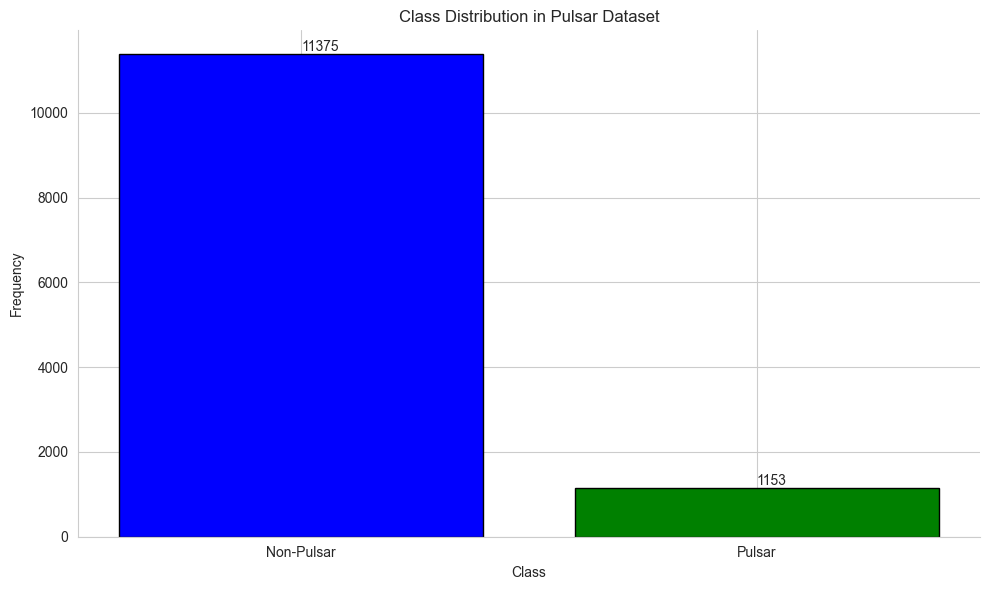

In [105]:
class_counts = df_imputed_scaled['target_class'].value_counts()

# Creating a bar plot for class distribution
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)  # To adjust the position of the bar plot for better aesthetics

# Creating the bar plot
bars = ax.bar(class_counts.index, class_counts.values, color=['blue', 'green'], edgecolor='black')

# Adding data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

# Customizing the plot to make it more professional
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Non-Pulsar', 'Pulsar'])
ax.set_ylabel('Frequency')
ax.set_xlabel('Class')
ax.set_title('Class Distribution in Pulsar Dataset')

# Show the plot
plt.tight_layout()
plt.show()

Based on the visualization of the class distribution for the Pulsar dataset, it is clear that there is a significant class imbalance present: the number of Non-Pulsar observations far exceeds the number of Pulsar observations. Specifically, there are 11,375 instances of the Non-Pulsar class and only 1,153 instances of the Pulsar class. This large discrepancy can lead to several issues:

1. **Model Bias**: Machine learning models might become biased towards the majority class.

2. **Overfitting**: There's a risk that the model might overfit to the majority class.

3. **Performance Metrics Misinterpretation**: Common metrics such as accuracy can be misleading, as a model that predicts every instance as Non-Pulsar would still achieve a high accuracy score due to the imbalance.

Given this analysis, we need to apply a technique to handle the class imbalance blance.

In this case, given the large imbalance and the relatively small number of Pulsar instances, over-sampling seems to be the preferable approach. Using a method like SMOTE to generate synthetic samples would be beneficial as it adds variety to the dataset without losing information, which might occur with under-sampling.

In [106]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

# Separating the features and target variable
X = df_imputed_scaled.drop('target_class', axis=1) 
y = df_imputed_scaled['target_class']  

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Original dataset shape {Counter(y_train)}")

# Applying SMOTE to the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled dataset shape {Counter(y_resampled)}")


Original dataset shape Counter({0.0: 7969, 1.0: 800})
Resampled dataset shape Counter({0.0: 7969, 1.0: 7969})


In [107]:
df_imputed_scaled = pd.concat([X_resampled, y_resampled], axis=1)
df_validation = pd.concat([X_test, y_test], axis=1)

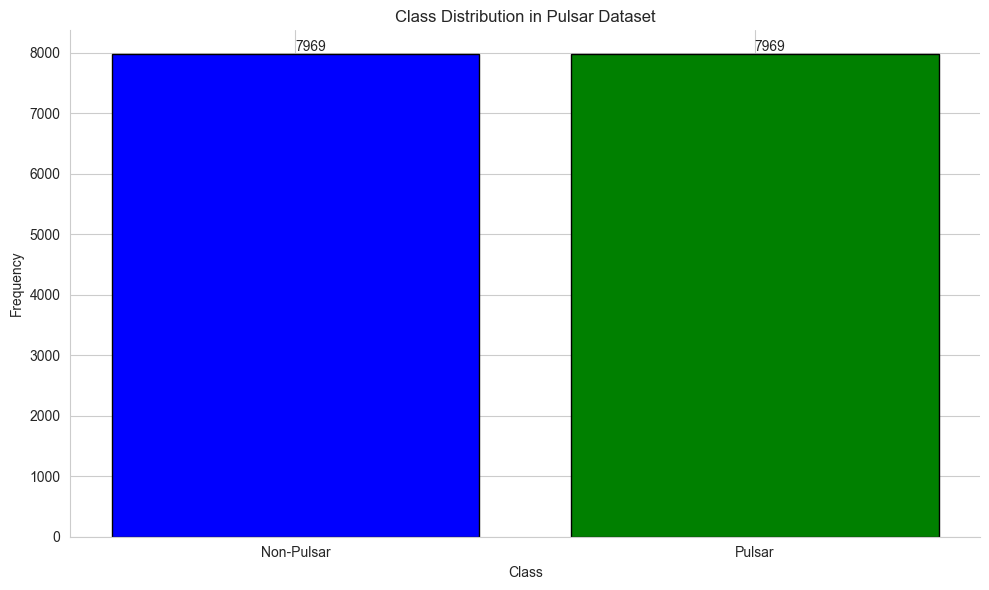

In [108]:
class_counts = df_imputed_scaled['target_class'].value_counts()

# Creating a bar plot for class distribution
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)  # To adjust the position of the bar plot for better aesthetics

# Creating the bar plot
bars = ax.bar(class_counts.index, class_counts.values, color=['blue', 'green'], edgecolor='black')

# Adding data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

# Customizing the plot to make it more professional
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Non-Pulsar', 'Pulsar'])
ax.set_ylabel('Frequency')
ax.set_xlabel('Class')
ax.set_title('Class Distribution in Pulsar Dataset')

# Show the plot
plt.tight_layout()
plt.show()

In [109]:
df_imputed_scaled.to_csv('../Datasets/Processed_data/pulsar_data_train_processed.csv', index=False)
df_validation.to_csv('../Datasets/Processed_data/pulsar_data_validation.csv', index=False)